In [456]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('monitoring_2024_dt.csv')

### Příprava dat pro model s využitím perf2_2_12

In [457]:
accepted_data = data.query('perf2_2_12 != "R" and perf2_2_12 != "O" and perf2_2_12 != "I"')
rejected_data = data[data['perf2_2_12'] == "R"]
accepted_data['perf2_2_12'].value_counts()

perf2_2_12
G    16326
B       89
Name: count, dtype: int64

### 1) Model na accepted datech

#### Výběr proměnných

In [458]:
variables = [
    'CAR_TYPE', 'TERM', 'AGE', 'CB_SCORE', 
    'DISPOSABLE_INCOME_CPI', 'LOAN_TO_VALUE', 
    'MARITAL_STATUS', 'TIME_AT_EMPLOYMENT','expert_score_cpi','perf2_2_12'
]
X = accepted_data[variables]
y = accepted_data['perf2_2_12']

In [459]:
#Transformace y 
# Vytvoření instance OneHotEncoder
encoder = LabelEncoder()
# Přizpůsobení a transformace y pomocí OneHotEncoder
y = encoder.fit_transform(y)
encoder.classes_ 
#0 - B
#1 - G

array(['B', 'G'], dtype=object)

#### Rozdělení dat

In [460]:
X_train_accepted, X_test_accepted, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### Uložení rozdělených dat bokem

In [461]:
X_test = X_test_accepted.copy()
X_train = X_train_accepted.copy()
X_test = X_test.drop(columns=['expert_score_cpi','perf2_2_12'])
X_train = X_train.drop(columns=['expert_score_cpi','perf2_2_12'])

#### Vytvoření dummy proměnných

In [462]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

#### Uložení dummy proměnných bokem

In [463]:
X_test_accepted_dummy = X_test.copy()
X_train_accepted_dummy = X_train.copy()

#### Výpočet modelu model['accepted'] 

In [464]:
model = {}
model['accepted'] = LogisticRegression(solver='lbfgs', max_iter=1000)
model['accepted'].fit(X_train, y_train)

LogisticRegression(max_iter=1000)

#### Predikce testovací data

In [466]:
y_pred_test = model['accepted'].predict(X_test)
y_prob_test = model['accepted'].predict_proba(X_test)
y_prob_class0_test = y_prob_test[:,0]
y_prob_class1_test = y_prob_test[:,1]
y_test = y_test.astype(float)

#### Predikce trénovací data

In [345]:
y_pred_train = model['accepted'].predict(X_train)
y_prob_train = model['accepted'].predict_proba(X_train)
y_prob_class0_train = y_prob_train[:,0]
y_prob_class1_train = y_prob_train[:,1]
y_train = y_train.astype(float)

### 2) Performance metriky pro model na accepted datech

##### test data

In [467]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test, y_prob_class1_test)
gini_test = auc_score*2-1
gini_test

0.6536454788802688

##### train data

In [347]:
auc_score = roc_auc_score(y_train, y_prob_class1_train)
gini_train = auc_score*2-1
gini_train

0.685811306694367

### 3) Distribuce pro model na accepted datech

In [ ]:
# Rozdělení y_prob_class1 na decily
# Aplikovat na dataset - vytvořit sloupec s rozdělením do skupin na zákl. decilů
# Pro každý decil spočítat BR
# Vygenerovat tabulku

#### Spojení dat

In [362]:
# test data
X_test_accepted_for_concat = X_test_accepted.copy()
X_test_accepted_for_concat['probab_good'] = y_prob_class1_test
# train data
X_train_accepted_for_concat = X_train_accepted.copy()
X_train_accepted_for_concat['probab_good'] = y_prob_class1_train
# spojení dat
train_test_accepted_data = pd.concat([X_test_accepted_for_concat, X_train_accepted_for_concat], axis= 0).reset_index()

#### Rozdělení na decily

In [363]:
deciles_accepted = np.percentile(train_test_accepted_data['probab_good'], np.arange(0, 100, 10))
y_prob_class_deciles_accepted = pd.qcut(train_test_accepted_data['probab_good'], 10, labels=False)

array([0.82544711, 0.98653169, 0.9928426 , 0.99555777, 0.99700747,
       0.99784115, 0.99852699, 0.9989799 , 0.9992196 , 0.99957866])

In [364]:
train_test_accepted_data['decile'] = y_prob_class_deciles_accepted
train_test_accepted_data['probab_bad'] = 1 - train_test_accepted_data['probab_good']

#### Decily zvlášť pro train a test data

In [370]:
#test data
deciles_accepted_test = np.percentile(X_test_accepted_for_concat['probab_good'], np.arange(0, 100, 10))
y_prob_class_deciles_test = pd.qcut(X_test_accepted_for_concat['probab_good'], 10, labels=False)
X_test_accepted_for_concat['decile'] = y_prob_class_deciles_test
X_test_accepted_for_concat['probab_bad'] = 1 - X_test_accepted_for_concat['probab_good']

#train data
deciles_accepted_train = np.percentile(X_train_accepted_for_concat['probab_good'], np.arange(0, 100, 10))
y_prob_class_deciles_train = pd.qcut(X_train_accepted_for_concat['probab_good'], 10, labels=False)
X_train_accepted_for_concat['decile'] = y_prob_class_deciles_train
X_train_accepted_for_concat['probab_bad'] = 1 - X_train_accepted_for_concat['probab_good']

#### Vytvoření distribuční tabulky

In [367]:
distribution_table = train_test_accepted_data.groupby('decile').apply(lambda x: pd.Series({
    'count_good': (x['perf2_2_12'] == 'G').sum(), 
    'count_bad': (x['perf2_2_12'] == 'B').sum(),   
    'avg_prob_good': x['probab_good'].mean(),  
    'avg_prob_bad': x['probab_bad'].mean(),    
    'bad_rate': (x['perf2_2_12'] == 'B').sum() / len(x)  
})).reset_index()
distribution_table['count_good'] = distribution_table['count_good'].astype(int)
distribution_table['count_bad'] = distribution_table['count_bad'].astype(int)
pd.options.display.float_format = '{:.6f}'.format
distribution_table

C:\Users\cza187adebec\AppData\Local\Temp\ipykernel_14116\3247893776.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  distribution_table = train_test_accepted_data.groupby('decile').apply(lambda x: pd.Series({


,decile,count_good,count_bad,avg_prob_good,avg_prob_bad,bad_rate
0,0,1592,50,0.971536,0.028464,0.030451
1,1,1623,18,0.990257,0.009743,0.010969
2,2,1635,7,0.994342,0.005658,0.004263
3,3,1639,2,0.996343,0.003657,0.001219
4,4,1642,3,0.997450,0.002550,0.001824
5,5,1636,2,0.998205,0.001795,0.001221
6,6,1638,3,0.998767,0.001233,0.001828
7,7,1654,2,0.999088,0.000912,0.001208
8,8,1638,1,0.999392,0.000608,0.000610
9,9,1629,1,0.999726,0.000274,0.000613


#### Distribuční tabulka zvlášť pro test a train data

In [368]:
#test data
distribution_table_test = X_test_accepted_for_concat.groupby('decile').apply(lambda x: pd.Series({
    'count_good': (x['perf2_2_12'] == 'G').sum(), 
    'count_bad': (x['perf2_2_12'] == 'B').sum(),   
    'avg_prob_good': x['probab_good'].mean(),  
    'avg_prob_bad': x['probab_bad'].mean(),    
    'bad_rate': (x['perf2_2_12'] == 'B').sum() / len(x)  
})).reset_index()
distribution_table_test['count_good'] = distribution_table_test['count_good'].astype(int)
distribution_table_test['count_bad'] = distribution_table_test['count_bad'].astype(int)
distribution_table_test

C:\Users\cza187adebec\AppData\Local\Temp\ipykernel_14116\2734518751.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  distribution_table_test = X_test_accepted_for_concat.groupby('decile').apply(lambda x: pd.Series({


,decile,count_good,count_bad,avg_prob_good,avg_prob_bad,bad_rate
0,0,479,14,0.971193,0.028807,0.028398
1,1,487,6,0.990180,0.009820,0.012170
2,2,490,2,0.994407,0.005593,0.004065
3,3,491,1,0.996385,0.003615,0.002033
4,4,492,1,0.997477,0.002523,0.002028
5,5,492,0,0.998224,0.001776,0.000000
6,6,493,2,0.998803,0.001197,0.004040
7,7,495,1,0.999116,0.000884,0.002016
8,8,486,0,0.999407,0.000593,0.000000
9,9,493,0,0.999732,0.000268,0.000000


In [369]:
#train data
distribution_table_train = X_train_accepted_for_concat.groupby('decile').apply(lambda x: pd.Series({
    'count_good': (x['perf2_2_12'] == 'G').sum(), 
    'count_bad': (x['perf2_2_12'] == 'B').sum(),   
    'avg_prob_good': x['probab_good'].mean(),  
    'avg_prob_bad': x['probab_bad'].mean(),    
    'bad_rate': (x['perf2_2_12'] == 'B').sum() / len(x)  
})).reset_index()
distribution_table_train['count_good'] = distribution_table_train['count_good'].astype(int)
distribution_table_train['count_bad'] = distribution_table_train['count_bad'].astype(int)
distribution_table_train

C:\Users\cza187adebec\AppData\Local\Temp\ipykernel_14116\2662145556.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  distribution_table_train = X_train_accepted_for_concat.groupby('decile').apply(lambda x: pd.Series({


,decile,count_good,count_bad,avg_prob_good,avg_prob_bad,bad_rate
0,0,1113,36,0.971687,0.028313,0.031332
1,1,1137,12,0.990288,0.009712,0.010444
2,2,1150,4,0.994321,0.005679,0.003466
3,3,1143,2,0.996329,0.003671,0.001747
4,4,1146,2,0.997438,0.002562,0.001742
5,5,1147,2,0.998197,0.001803,0.001741
6,6,1148,2,0.998753,0.001247,0.001739
7,7,1153,0,0.999075,0.000925,0.000000
8,8,1145,1,0.999383,0.000617,0.000873
9,9,1146,1,0.999723,0.000277,0.000872


### Kontrola distribuce dat

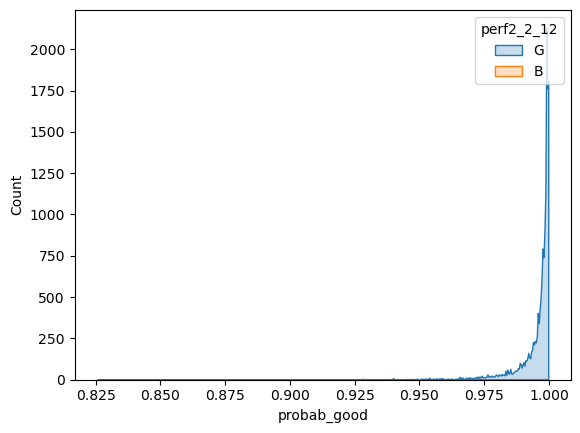

In [249]:
#neupravováno
import seaborn as sns
ax = sns.histplot(
    data=enriched_accepted_data,
    x="probab_good",
    hue="perf2_2_12",
    element="poly"
)

### 4) Simple Augmentation

#### Příprava proměnných

In [371]:
variables_rejected = [
    'CAR_TYPE', 'TERM', 'AGE', 'CB_SCORE', 
    'DISPOSABLE_INCOME_CPI', 'LOAN_TO_VALUE', 
    'MARITAL_STATUS', 'TIME_AT_EMPLOYMENT'
]

#### 4.1) Spočítání model['accepted'] na rejected datech

In [374]:
rejected_data_dummy = pd.get_dummies(rejected_data[variables_rejected], columns=variables_rejected)
rejects_prob_class1 = model['accepted'].predict_proba(rejected_data_dummy)[:, list(model['accepted'].classes_).index(1)]

In [ ]:
BR_cutoff = 0.025
cut_off_value = np.quantile(rejects_prob_class1, BR_cutoff)
rejected_data.loc[:,'probab_good'] = rejects_prob_class1
rejected_data.loc[:,'Predicted_Performance'] = np.where(rejected_data.loc[:,'probab_good'] < cut_off_value, 0, 1)

In [377]:
cut_off_value

0.9401642419452598

In [378]:
rejected_data['probab_good'].describe()

count   4275.000000
mean       0.989448
std        0.016510
min        0.818959
25%        0.987948
50%        0.995616
75%        0.998417
max        0.999895
Name: probab_good, dtype: float64

In [379]:
rejected_data["Predicted_Performance"].value_counts()

Predicted_Performance
1    4168
0     107
Name: count, dtype: int64

#### Kontrola distribuce

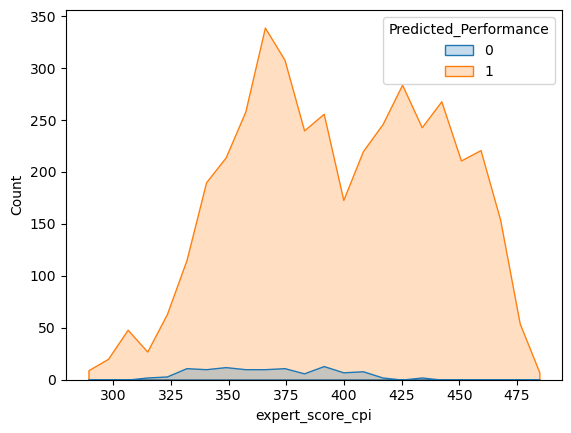

In [380]:
import seaborn as sns
ax = sns.histplot(
    data=rejected_data,
    x="expert_score_cpi",
    hue="Predicted_Performance",
    element="poly"
)

### 4.2) Spojení accepted a rejected dat

In [382]:
    #Překódování Predicted Performance na 0 a 1, 0 - B, 1 - G
X_train_accepted_for_concat.loc[:,'Predicted_Performance'] = X_train_accepted_for_concat.loc[:,'perf2_2_12']
X_train_accepted_for_concat.loc[:,'Predicted_Performance'] = encoder.fit_transform(X_train_accepted_for_concat['Predicted_Performance'])
X_train_accepted_rejected_combined = pd.concat([X_train_accepted_for_concat, rejected_data], ignore_index=True)

#### Kontrola distribuce

In [383]:
X_train_accepted_rejected_combined['Predicted_Performance'].value_counts()

Predicted_Performance
1    15596
0      169
Name: count, dtype: int64

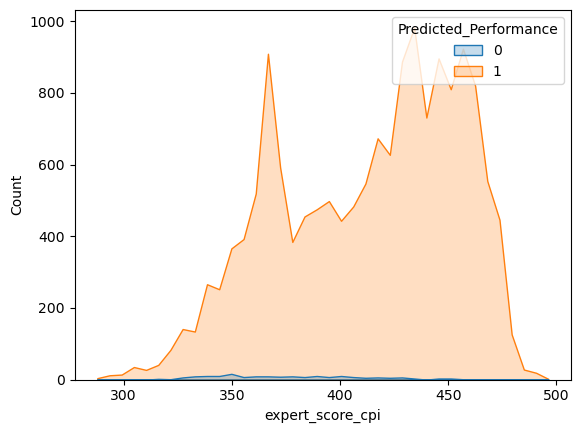

In [384]:
import seaborn as sns
ax = sns.histplot(
    data=X_train_accepted_rejected_combined,
    x="expert_score_cpi",
    hue="Predicted_Performance",
    element="poly"
)

### 4.3) Znovuspočítání modelu po navýšení počtu bad

#### Příprava proměnných

In [418]:
variables_combined = [
    'CAR_TYPE', 'TERM', 'AGE', 'CB_SCORE', 
    'DISPOSABLE_INCOME_CPI', 'LOAN_TO_VALUE', 
    'MARITAL_STATUS', 'TIME_AT_EMPLOYMENT'
]
X_combined = X_train_accepted_rejected_combined[variables_combined]
y_combined = X_train_accepted_rejected_combined['Predicted_Performance']

#### Rozdělení datasetu

In [419]:
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42, stratify=y_combined)

#### Převedení na dummy a uložení proměnných

In [420]:
X_train_combined_dummy = pd.get_dummies(X_train_combined, columns=variables_combined)
X_test_combined_dummy = pd.get_dummies(X_test_combined, columns=variables_combined)
y_train_combined = y_train_combined.astype(int)
y_test_combined = y_test_combined.astype(int)

#### Výpočet modelu model['combined']

In [421]:
model['combined'] = LogisticRegression(solver='lbfgs', max_iter=1000)
model['combined'].fit(X_train_combined_dummy, y_train_combined)

LogisticRegression(max_iter=1000)

In [423]:
#predikce pro test data
y_pred_test_combined = model['combined'].predict(X_test_combined_dummy)
y_prob_test_combined = model['combined'].predict_proba(X_test_combined_dummy)
y_prob_class0_test_combined = y_prob_test_combined[:,0]
y_prob_class1_test_combined = y_prob_test_combined[:,1]

In [424]:
#pro train data
y_pred_train_combined = model['combined'].predict(X_train_combined_dummy)
y_prob_train_combined = model['combined'].predict_proba(X_train_combined_dummy)
y_prob_class0_train_combined = y_prob_train_combined[:,0]
y_prob_class1_train_combined = y_prob_train_combined[:,1]

#### Performance metriky

##### test data

In [425]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test_combined, y_prob_class1_test_combined)
gini = auc_score*2-1
gini

0.8314747997938217

##### train data

In [426]:
auc_score = roc_auc_score(y_train_combined, y_prob_class1_train_combined)
gini = auc_score*2-1
gini

0.8658863566851887

#### Performance metriky na test accepted datech

In [427]:
print("Počet záznamů v X_test_accepted:", len(X_test_accepted_dummy))
print("Počet záznamů v y_test_accepted:", len(y_test_accepted))

Počet záznamů v X_test_accepted: 4925
Počet záznamů v y_test_accepted: 4925


In [428]:
y_prob_accepted_test_combined = model['combined'].predict_proba(X_test_accepted_dummy)
y_prob_class0_accepted_test_combined = y_prob_accepted_test_combined[:,0]
y_prob_class1_accepted_test_combined = y_prob_accepted_test_combined[:,1]

In [429]:
auc_score = roc_auc_score(y_test_accepted, y_prob_class1_accepted_test_combined)
gini = auc_score*2-1
gini

0.600320614612162

In [434]:
pd.DataFrame(y_test_accepted).value_counts()

0
1    4898
0      27
Name: count, dtype: int64

#### Distribuce na accepted datech

In [ ]:
# Rozdělení y_prob_class1_accepted_test na decily
# Aplikovat na dataset - vytvořit sloupec s rozdělením do skupin na zákl. decilů
# Pro každý decil spočítat BR
# Vygenerovat tabulku

In [449]:
X_test_accepted_combined_m_distribution = X_test_accepted.copy()
X_test_accepted_combined_m_distribution['probab_good'] = y_prob_class1_accepted_test_combined
X_test_accepted_combined_m_distribution['probab_bad'] = 1 - y_prob_class1_accepted_test_combined

In [450]:
deciles_accepted_test_combined = np.percentile(X_test_accepted_combined_m_distribution['probab_good'], np.arange(0, 100, 10))
y_prob_accepted_test_combined_class_deciles = pd.qcut(X_test_accepted_combined_m_distribution['probab_good'], 10, labels=False)
deciles_accepted_test_combined

array([0.28396771, 0.98680479, 0.99638051, 0.99848102, 0.99919518,
       0.99957367, 0.9997241 , 0.99986592, 0.99993545, 0.99997642])

In [451]:
X_test_accepted_combined_m_distribution['decile'] = y_prob_accepted_test_combined_class_deciles

In [452]:
X_test_accepted_combined_m_distribution['probab_good'].describe()

count   4925.000000
mean       0.992400
std        0.033135
min        0.283968
25%        0.997786
50%        0.999574
75%        0.999908
max        0.999998
Name: probab_good, dtype: float64

In [453]:
#train data
distribution_table = X_test_accepted_combined_m_distribution.groupby('decile').apply(lambda x: pd.Series({
    'count_good': (x['perf2_2_12'] == 'G').sum(), 
    'count_bad': (x['perf2_2_12'] == 'B').sum(),   
    'avg_prob_good': x['probab_good'].mean(),  
    'avg_prob_bad': x['probab_bad'].mean(),    
    'bad_rate': (x['perf2_2_12'] == 'B').sum() / len(x)  
})).reset_index()
distribution_table['count_good'] = distribution_table['count_good'].astype(int)
distribution_table['count_bad'] = distribution_table['count_bad'].astype(int)
distribution_table

C:\Users\cza187adebec\AppData\Local\Temp\ipykernel_14116\8059532.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  distribution_table = X_test_accepted_combined_m_distribution.groupby('decile').apply(lambda x: pd.Series({


,decile,count_good,count_bad,avg_prob_good,avg_prob_bad,bad_rate
0,0,479,14,0.935537,0.064463,0.028398
1,1,490,2,0.993240,0.006760,0.004065
2,2,489,4,0.997661,0.002339,0.008114
3,3,493,2,0.998880,0.001120,0.004040
4,4,490,1,0.999412,0.000588,0.002037
5,5,490,1,0.999670,0.000330,0.002037
6,6,490,2,0.999807,0.000193,0.004065
7,7,497,1,0.999907,0.000093,0.002008
8,8,488,0,0.999960,0.000040,0.000000
9,9,492,0,0.999987,0.000013,0.000000


## Vizualizace

In [184]:
X_test_accepted['predicted'] = y_pred_accepted

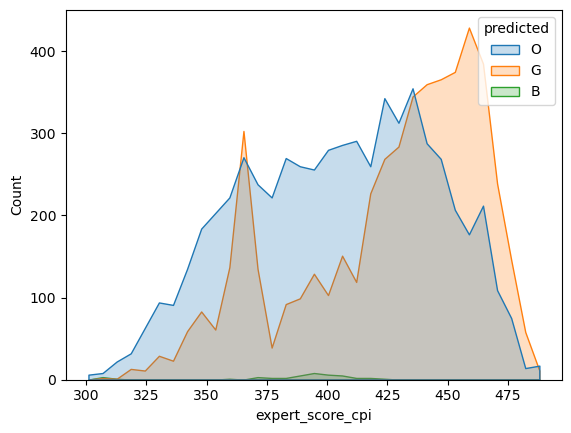

In [181]:
ax = sns.histplot(
    data=X_test_accepted,
    x="expert_score_cpi",
    hue="predicted",
    element="poly"
)

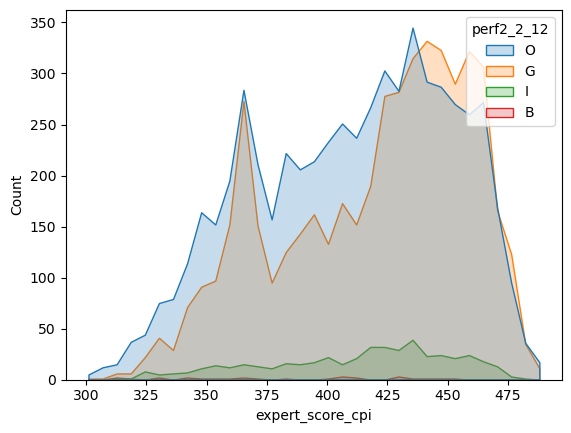

In [182]:
ax = sns.histplot(
    data=X_test_accepted,
    x="expert_score_cpi",
    hue="perf2_2_12",
    element="poly"
)

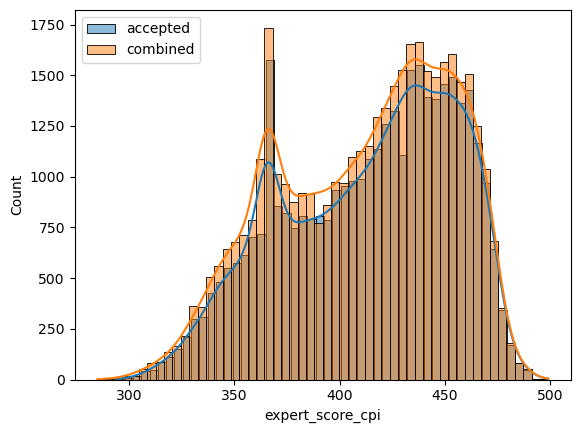

In [194]:
import matplotlib.pyplot as plt
sns.histplot(data=accepted_data['expert_score_cpi'], label = "accepted", kde=True)
sns.histplot(data=combined_data['expert_score_cpi'], label = "combined", kde=True)
plt.legend()
plt.show()

In [196]:
bins = [-float('inf'), 358, 373, 386, 396, 408, 419, 434, 447, 461, float('inf')]
labels = ["<=358", "359 - 373", "374 - 386", "387 - 396", "397 - 408", "409 - 419",
          "420 - 434", "435 - 447", "448 - 461", ">=462"]
combined_data.loc[:,'score_category'] = pd.cut(combined_data['expert_score_cpi'], bins=bins, labels=labels)
accepted_data.loc[:,'score_category'] = pd.cut(accepted_data['expert_score_cpi'], bins=bins, labels=labels)

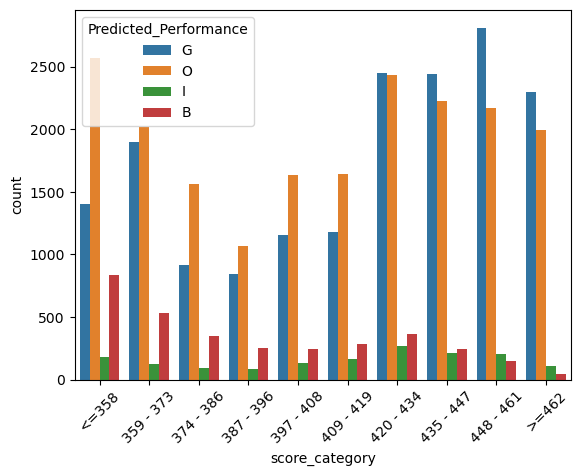

In [200]:
ax = sns.countplot(
    data=combined_data,
    x="score_category",
    hue="Predicted_Performance"
)
ax.tick_params(axis="x", rotation=45)

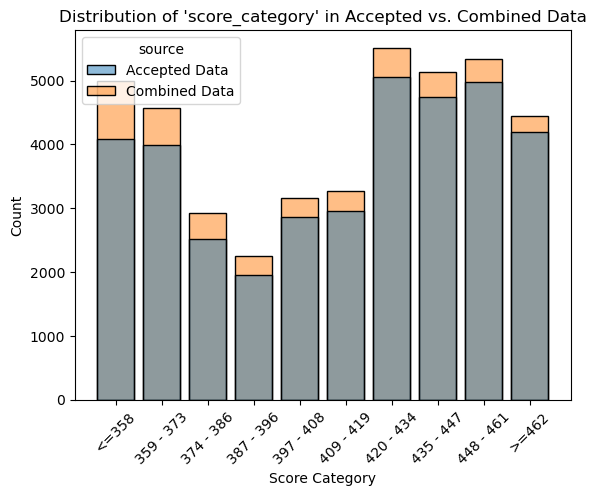

In [202]:
accepted_data.loc[:,'source'] = 'Accepted Data'
combined_data.loc[:,'source'] = 'Combined Data'
plot_data = pd.concat([accepted_data, combined_data], ignore_index=True)
sns.histplot(data=plot_data, x='score_category', hue='source',shrink=0.8, alpha = 0.5)
plt.title("Distribution of 'score_category' in Accepted vs. Combined Data")
plt.xlabel("Score Category")
plt.xticks(rotation=45)
plt.show()